## FEATURE EXTRACTION USING AUTOENCODER

### UNSUPERVISED NEURAL NETWORK
input -> encoder (It learns how to efficiently compress and encode the data) -> "code" ->  decoder (It learns how to reconstructs the data representation) -> output (which is almost same as input image / both have same size)

to remove unnecessary details to reduce dimension space & to learn relevant features of image

![alt text](autoencoders.png "Title")

![alt text](encoderpipeline.png "Title")

In [36]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import cifar10
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import pickle
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization,Dropout
from keras.models import Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
classLabel = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
(X_train,y_train),(X_test,y_test) = cifar10.load_data()

In [3]:
# since every value in image is ranging from 0 to 255, need to normalize the data to uniform range of 0-1 , diving by 255
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train = X_train/255
X_test = X_test/255

In [13]:
print(X_train.shape,X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [44]:
checkpointer = ModelCheckpoint("save/autoencoder.hdf5", verbose=0, save_best_only=True) # save best model
earlyStop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
# convulational layers
# input = Input(shape=(32,32,3))   # 32,32,3

# # encoder
# x = Conv2D(64,(3,3),activation="relu",padding="same") (input)  
# x = MaxPooling2D((2,2))(x)  # reduces dimension / downsampling  

# x = Conv2D(32,(3,3),activation="relu",padding="same") (x)   
# x = MaxPooling2D((2,2))(x)

# x = Conv2D(16,(3,3),activation="relu",padding="same") (x)
# # x = MaxPooling2D((2,2))(x)

# x = Conv2D(8,(3,3),activation="relu",padding="same") (x)  # 8 x 8
# encoded = MaxPooling2D((2,2),padding="same",name="encoded_layer")(x)  # bottleneck


# # decoder
# x = Conv2D(8,(3,3),activation="relu",padding="same") (encoded)
# x = UpSampling2D((2,2))(x)

# x = Conv2D(16,(3,3),activation="relu",padding="same") (x)
# x = UpSampling2D((2,2))(x)

# x = Conv2D(32,(3,3),activation="relu",padding="same") (x)
# x = UpSampling2D((2,2))(x)

# reconstruct = Conv2D(64,(3,3),activation="relu",padding="same") (x)

# decoded = Conv2D(3,(3,3),padding="same") (reconstruct)

# autoencoder = Model(input,decoded)
# autoencoder.compile(optimizer="adam",loss="mse",metrics=["accuracy"])
# autoencoder.summary()

input_image = Input(shape=(32,32,3))

# Encoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded_layer')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), padding='same')(x)

autoencoder = Model(input_image, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse',metrics=["accuracy"])
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 encoded_layer (MaxPooling2D  (None, 8, 8, 128)        0         
 )                                                               
                                                                 
 conv2d_62 (Conv2D)          (None, 8, 8, 128)         1475

In [ ]:
history = autoencoder.fit(X_train,X_train, validation_split=0.2, callbacks=[earlyStop,checkpointer],verbose=1,epochs=50, batch_size=256, shuffle=True)

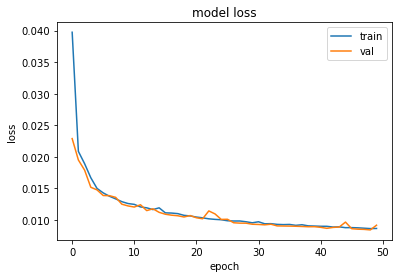

In [21]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [22]:
model = load_model("save/autoencoder.hdf5")
encoder = Model(inputs=model.input,outputs=model.get_layer('encoded_layer').output)

encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 8, 8, 16)          4624

In [24]:
new_X_train = encoder.predict(X_train)
new_X_test = encoder.predict(X_test)

In [25]:
print(new_X_train.shape,new_X_test.shape) 

(50000, 4, 4, 8) (10000, 4, 4, 8)


In [26]:
X_train1 = new_X_train.reshape((len(X_train),-1))
print(X_train1.shape)
X_test1 = new_X_test.reshape((len(X_test),-1))
print(X_test1.shape)

(50000, 128)
(10000, 128)


In [27]:
y_train1 = y_train.flatten()
print(y_train1.shape)
y_test1 = y_test.flatten()
print(y_test1.shape)

(50000,)
(10000,)


## SVM on AUTOENCODER

In [33]:
from sklearn.svm import SVC
import time

In [34]:
start = time.time()

svc_enc = SVC(kernel="rbf")
svc_enc.fit(X_train1,y_train1)

end = time.time()
print("Time Taken (SVM using Autoencoder) :",(end-start)/60,"minutes")

Time Taken (SVM using Autoencoder) : 7.752304844061533 minutes


In [35]:
svc_pred = svc_enc.predict(X_test1)
acc20 = accuracy_score(svc_pred,y_test1)
print("Accuracy Score (Support Vector Machines using Autoencoder) :",accuracy_score(svc_pred,y_test1))
print("Confusion matrix (Support Vector Machines using Autoencoder)\n",confusion_matrix(svc_pred,y_test1))
print("Classification Report (Support Vector Machines using Autoencoder)\n",classification_report(svc_pred,y_test1))

Accuracy Score (Support Vector Machines using Autoencoder) : 0.4826
Confusion matrix (Support Vector Machines using Autoencoder)
 [[546  35  98  31  44  26   5  45  90  41]
 [ 36 582  26  29  19  26  18  27  67 169]
 [ 63  29 340  83 147  99  92  56  16  14]
 [ 23  28  92 336  61 185  73  76  23  37]
 [ 19  11 132  64 384  70 105 111  17  15]
 [ 14  30  60 166  45 363  49  63  28  24]
 [ 27  27 147 148 174  94 607  57  14  30]
 [ 31  30  57  50  77  74  25 460  20  40]
 [187  68  34  34  33  35  13  29 649  71]
 [ 54 160  14  59  16  28  13  76  76 559]]
Classification Report (Support Vector Machines using Autoencoder)
               precision    recall  f1-score   support

           0       0.55      0.57      0.56       961
           1       0.58      0.58      0.58       999
           2       0.34      0.36      0.35       939
           3       0.34      0.36      0.35       934
           4       0.38      0.41      0.40       928
           5       0.36      0.43      0.39    